In [1]:
%load_ext autoreload
%autoreload 2
import sys

path = "C:/Users/schiavaz/lava-nc/depth/"
sys.path.append(path)

import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import open3d as o3d
import scipy.io

import events_utils.filter as flt
import events_utils.visualize as vis
import events_utils.time_difference as td

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [206]:
events_raw = scipy.io.loadmat(path + "/data/stripes.mat")
events_rel = events_raw["events"]
events = np.zeros(events_rel.shape)
events[:,0] = events_rel[:,3] * 10e-6
events[:,1:] = events_rel[:,:3]

events_raw = events

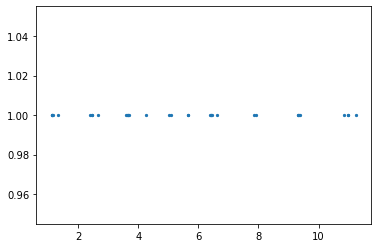

In [207]:
px = events_raw[np.logical_and(events_raw[:,2]==100, events_raw[:,1] == 10)]
plt.scatter(px[:,0], np.ones(px[:,0].shape), s=5)

In [227]:
events_ref = flt.filter_refract(events_raw, 0.5)


In [290]:
start_time = 0.5
duration = 0.5
events_t = flt.filter_time(events_ref, start_time, start_time+duration)
events_t.shape

(6881, 4)

In [291]:
px = events_t[np.logical_and(events_t[:,2]==100, events_t[:,1] == 67)]
plt.scatter(px[:,0], np.ones(px[:,0].shape), s=5)

In [292]:
px = events_t[np.logical_and(events_t[:,2]==100, events_t[:,1] == 66)]
plt.scatter(px[:,0], np.ones(px[:,0].shape), s=5)

In [323]:
patch_center = (100, 59)
patch_size = 10
shape = (patch_size, patch_size)
events = flt.filter_patch(events_t, patch_center, patch_size)
events.shape

(83, 4)

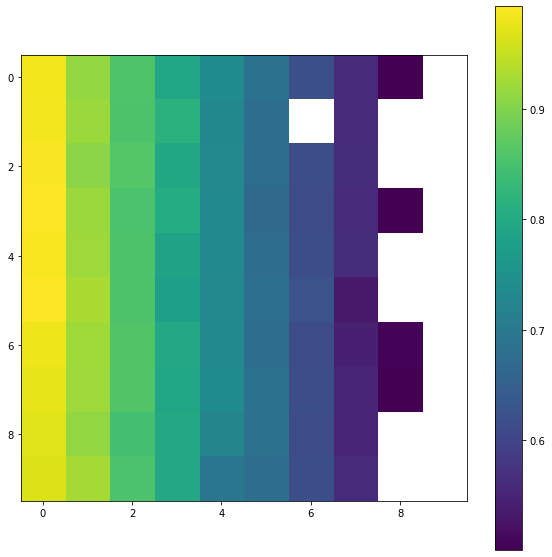

In [324]:
%matplotlib inline
plt.figure(figsize=(10, 10))
img = vis.events2time_surf(events, shape, filter_polarity=False)
img_m = np.ma.masked_where(img == 0, img)
m = plt.imshow(img_m, interpolation="none")
plt.colorbar(mappable=m)

In [325]:
%matplotlib qt
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
ax.scatter(events[:,0], events[:,1], events[:,2])

In [326]:
time_diff = td.compute_time_difference(events, shape, polarity=1, dist=1) / 1

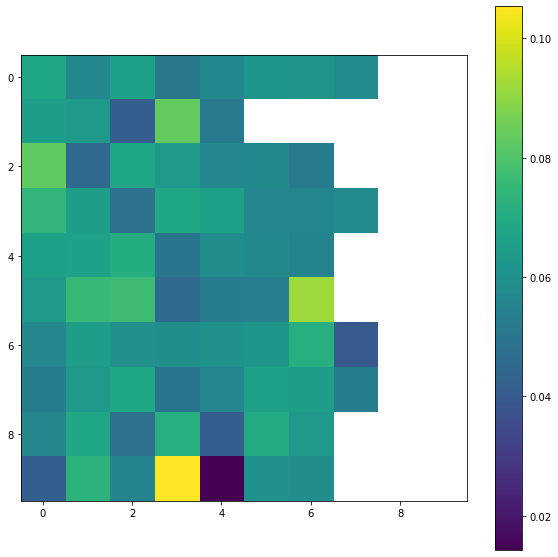

In [327]:
%matplotlib inline
plt.figure(figsize=(10, 10))
img_m = np.ma.masked_where(time_diff == 0, time_diff)
m = plt.imshow(img_m, interpolation="none")
plt.colorbar(mappable=m)

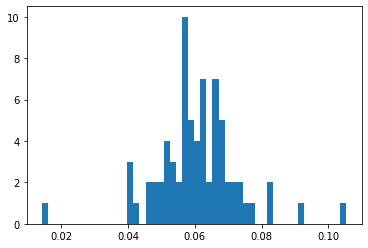

In [328]:
plt.hist(img_m.compressed(), 50);

In [329]:
td_warped = td.compute_time_difference_warped(events, shape, start_time, shape, polarity=1, filter_polarity=True)
td_w_median, count_med = td.median_from_dict(td_warped, shape, 1)
td_w_mean, cont_mean = td.mean_from_dict(td_warped, shape, 1)

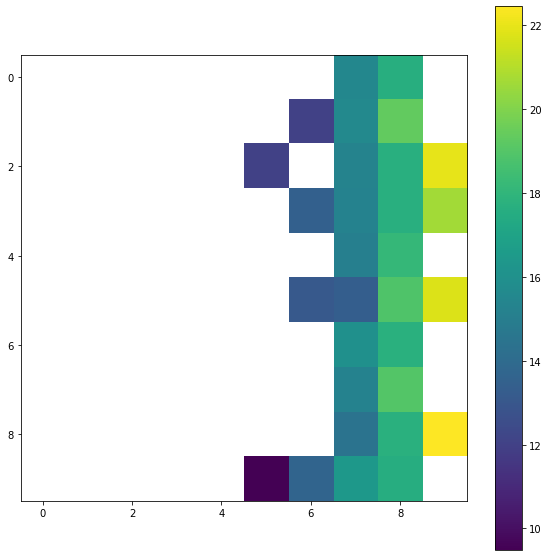

In [330]:
%matplotlib inline
plt.figure(figsize=(10, 10))
img_m = np.ma.masked_where(td_w_median == 0, td_w_median)
m = plt.imshow(img_m, interpolation="none")
plt.colorbar(mappable=m)

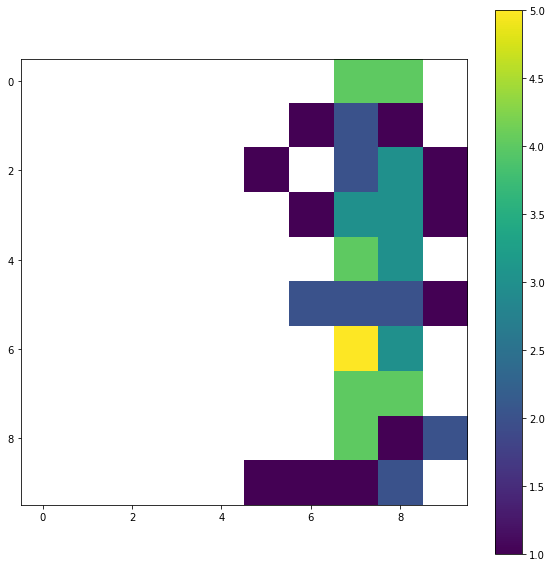

In [331]:
%matplotlib inline
plt.figure(figsize=(10, 10))
img_m = np.ma.masked_where(count_med == 0, count_med)
m = plt.imshow(img_m, interpolation="none")
plt.colorbar(mappable=m)

In [342]:
row = 2
last_time = np.full(shape, -1.0)
td_predictions = {}
predictions = {}
px_range_pred = 5
dist = 1
for e in events:
#     if e[2] != row:
#         continue
    x = int(e[1])
    y = int(e[2])
    
    last_time[y, x] = e[0]
    
    if x >= shape[1]-dist:
        continue
    if last_time[y, x+dist] == -1:
        continue
            
    time_difference = (last_time[y, x] - last_time[y, x+dist]) / dist
    #rint(time_difference)
    
    for i in range(1, px_range_pred +1):
        for k in range(-int(px_range_pred / 2), int(px_range_pred / 2)):
            y_p = y + k
            x_p = x - i
            pred_time = last_time[y, x] + time_difference * i

            if x_p < 0 or y_p < 0 or y_p >= shape[0]:
                continue

            if (y_p, x_p) in predictions:
                predictions[y_p, x_p].append(pred_time)
                td_predictions[y_p, x_p].append(time_difference)
            else:
                predictions[y_p, x_p] = [pred_time]
                td_predictions[y_p, x_p] = [time_difference]
    

In [343]:
predictions.keys()

dict_keys([(4, 6), (5, 6), (6, 6), (7, 6), (4, 5), (5, 5), (6, 5), (7, 5), (4, 4), (5, 4), (6, 4), (7, 4), (4, 3), (5, 3), (6, 3), (7, 3), (4, 2), (5, 2), (6, 2), (7, 2), (8, 6), (8, 5), (8, 4), (8, 3), (8, 2), (1, 6), (2, 6), (3, 6), (1, 5), (2, 5), (3, 5), (1, 4), (2, 4), (3, 4), (1, 3), (2, 3), (3, 3), (1, 2), (2, 2), (3, 2), (0, 6), (0, 5), (0, 4), (0, 3), (0, 2), (9, 5), (9, 4), (9, 3), (9, 2), (6, 1), (7, 1), (8, 1), (9, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (0, 1), (1, 0), (2, 0), (3, 0), (4, 0), (0, 0), (5, 0), (6, 0), (7, 0), (8, 0), (9, 0)])

In [344]:
len(predictions[9, 0])

10

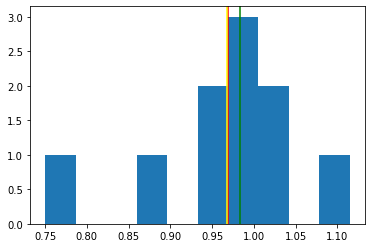

In [345]:
plt.hist(predictions[9, 0], 10);

t = events[np.logical_and(events[:,1] == 0, events[:,2]==9)][0,0]

mean = np.mean(predictions[9, 0])
median = np.median(predictions[9, 0])

plt.axvline(x=t, color="red", label="mean")
plt.axvline(x=mean, color="yellow", label="mean")
plt.axvline(x=median, color="green", label="mean")

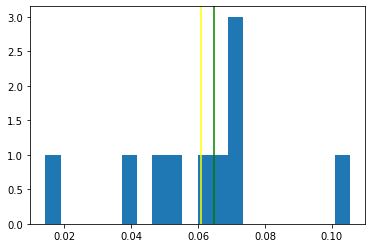

In [346]:
plt.hist(td_predictions[9, 0], 20);

#t = events[np.logical_and(events[:,1] == 0, events[:,2]==2)][0,0]

mean = np.mean(td_predictions[9, 0])
median = np.median(td_predictions[9, 0])

#plt.axvline(x=t, color="red", label="mean")
plt.axvline(x=mean, color="yellow", label="mean")
plt.axvline(x=median, color="green", label="mean")

In [347]:
events[np.logical_and(events[:,1] == 0, events[:,2]==2)][0, 0]

0.9916200000000001

In [349]:
u = 1.0 / 0.02

v = 0.2901460156636141
f = 335.419462958

d = f / u * v

In [350]:
d

1.9464124150658577

In [146]:
u = 1.0 / 0.03

v = 0.2901460156636141
f = 335.419462958

d = f / u * v
d

2.9196186225987866

In [147]:
u = 1.0 / 0.02

v = 0.2901460156636141
f = 335.419462958

d = f / u * v
d

1.9464124150658577

In [348]:
v = 0.2901460156636141
f = 335.419462958

d_min = 0.1
d_max = 2.4

u_min = (v / d_min) * f
u_max = (v / d_max) * f

print(u_min)
print(u_max)

973.2062075329288
40.550258647205375


In [253]:
td_min = 1 / u_min
td_max = 1 / u_max

print(td_min)
print(td_max)

0.0010275314648218216
0.02466075515572371


In [249]:
d = np.linspace(0.1, 3, 100)

u = (v / d) * f
t = 1 / u
print(t)

[0.00102753 0.00132853 0.00162952 0.00193051 0.00223151 0.0025325
 0.0028335  0.00313449 0.00343548 0.00373648 0.00403747 0.00433847
 0.00463946 0.00494045 0.00524145 0.00554244 0.00584344 0.00614443
 0.00644542 0.00674642 0.00704741 0.00734841 0.0076494  0.00795039
 0.00825139 0.00855238 0.00885338 0.00915437 0.00945537 0.00975636
 0.01005735 0.01035835 0.01065934 0.01096034 0.01126133 0.01156232
 0.01186332 0.01216431 0.01246531 0.0127663  0.01306729 0.01336829
 0.01366928 0.01397028 0.01427127 0.01457226 0.01487326 0.01517425
 0.01547525 0.01577624 0.01607723 0.01637823 0.01667922 0.01698022
 0.01728121 0.01758221 0.0178832  0.01818419 0.01848519 0.01878618
 0.01908718 0.01938817 0.01968916 0.01999016 0.02029115 0.02059215
 0.02089314 0.02119413 0.02149513 0.02179612 0.02209712 0.02239811
 0.0226991  0.0230001  0.02330109 0.02360209 0.02390308 0.02420407
 0.02450507 0.02480606 0.02510706 0.02540805 0.02570904 0.02601004
 0.02631103 0.02661203 0.02691302 0.02721402 0.02751501 0.02781

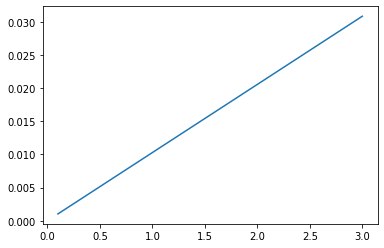

In [217]:
plt.plot(d, t)

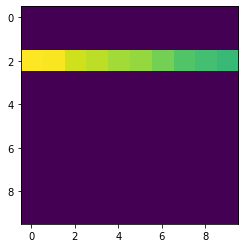

In [176]:
plt.imshow(last_time)

In [322]:
events[np.logical_and(events[:,1] == 0, events[:,2]==2)]

array([], shape=(0, 4), dtype=float64)